In [1]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# remove useless Tensorflow warning:
# WARNING:absl:Found untraced functions such as _update_step_xla, lstm_cell_1_layer_call_fn, 
# lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, 
# lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 5). 
# These functions will not be directly callable after loading.
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

#### RNN: Formula Label Prediction (Variant 3: Stream of math types and tokens)

In [3]:
import numpy as np 
import pandas as pd
from pathlib import Path 

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import datetime

tfds.disable_progress_bar()
wandb_project_name = "binary_formula_classification"

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [5]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["type_tokens"] = corpus["type_tokens"].map(process_cell)
    corpus["tokens"] = corpus["tokens"].map(process_cell)

In [6]:
#print(os.getcwd())
data_p = Path("../data/") / "bin_class_data_TOKENIZED_SET_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()

,tokens,type_tokens,label
0,f : A \to B,func_def func_name __ANON_1 COLON mapping __AN...,1
1,f,func_name __ANON_1,1
2,g \colon B \to I,func_def func_name __ANON_1 COLON mapping __AN...,1
3,\frac { 8 ! } { ( 8 - 4 ) ! },expr_atom CMD_FRAC L_BRACE postfix expr_atom _...,1
4,f,func_name __ANON_1,1


In [7]:
print(data["type_tokens"].map(lambda x: len((x.split(" ")))).max())
print(data["tokens"].map(lambda x: len((x.split(" ")))).max())

126
104


In [8]:
SIZE_TRAIN_DS = 10000
SIZE_TEST_DS = 1000
data_as_ds = tf.data.Dataset.from_tensor_slices((data["tokens"],data["type_tokens"]))
labels_ds = tf.data.Dataset.from_tensor_slices(data["label"])
data_as_ds = tf.data.Dataset.zip((data_as_ds, labels_ds))
test_dataset = data_as_ds.take(SIZE_TEST_DS)
train_dataset = data_as_ds.skip(SIZE_TEST_DS)

In [9]:
data_as_ds.element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.string, name=None)),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

##### Setup and Data Preparation

In [10]:
for (example_token, example_type), label in train_dataset.take(5):
    print("text: ", example_token.numpy())
    print("type: ", example_type.numpy())
    print("label: ", label.numpy())

text:  b'f'
type:  b'func_name __ANON_1'
label:  1
text:  b'f'
type:  b'func_name __ANON_1'
label:  1
text:  b'f : X \\rightarrow Y'
type:  b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0'
label:  1
text:  b'mathbb{R'
type:  b'set_constant SET_BASIC'
label:  1
text:  b'g : \\mathbb{N} \\to X'
type:  b'func_def func_name __ANON_1 COLON mapping set_constant SET_BASIC TO __ANON_0'
label:  1


In [11]:
BUFFER_SIZE = SIZE_TRAIN_DS
BATCH_SIZE = 64
STEPS_PER_EPOCH = np.floor(SIZE_TRAIN_DS/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.floor(SIZE_TEST_DS/BATCH_SIZE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [12]:
# for int encoder
TYPE_TOKENS_MAX_SEQ_LEN = 130 
TOKENS_MAX_SEQ_LEN = 110

# for other encoders 
TYPE_TOKENS_PAD_TO_MAX_TOKENS = 100 
TOKENS_PAD_TO_MAX_TOKENS = 150
BIGRAM_PAD_TO_MAX_TOKENS = 350

In [13]:
def create_encoder(output_mode_str, n_grams, mode):
    if output_mode_str == "int":
        VOCAB_SIZE = 200
        if mode == "token":
            max_seq_len = TOKENS_MAX_SEQ_LEN
        elif mode == "type":
            max_seq_len = TYPE_TOKENS_MAX_SEQ_LEN

        encoder = tf.keras.layers.TextVectorization(
            standardize=None,
            output_mode=output_mode_str,
            ngrams = n_grams,
            output_sequence_length = max_seq_len,
            split="whitespace",
            max_tokens=VOCAB_SIZE)
        #TODO: adapt for different inputs
        if mode == "token": 
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
        elif mode == "type":
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
        return encoder
    
    if output_mode_str == "count" and n_grams == 2:
        max_seq_len = BIGRAM_PAD_TO_MAX_TOKENS
        encoder = tf.keras.layers.TextVectorization(
            standardize=None,
            output_mode=output_mode_str,
            ngrams = n_grams,
            pad_to_max_tokens = max_seq_len,
            split="whitespace",
            max_tokens=max_seq_len)
        
        #TODO: adapt for different inputs
        if mode == "token": 
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
        elif mode == "type":
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
        return encoder
    
    if mode == "token":
        max_seq_len = TOKENS_PAD_TO_MAX_TOKENS
    elif mode == "type":
        max_seq_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        pad_to_max_tokens = max_seq_len,
        split="whitespace",
        max_tokens=max_seq_len)
    #TODO: adapt for different inputs
    if mode == "token": 
        encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
    elif mode == "type":
        encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
    
    return encoder


    

##### Representation 1: Use integer indices encoding

In [14]:
encoder_int_tokens = create_encoder("int", None, "token")
encoder_int_types = create_encoder("int", None, "type")

vocab_tokens = np.array(encoder_int_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_int_tokens.get_vocabulary())
vocab_types = np.array(encoder_int_types.get_vocabulary())
vocab_size_types = len(encoder_int_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
tokens (voc size):  123
types (voc size):  59


In [15]:
encoded_example_token = encoder_int_tokens(example_token).numpy()
encoded_example_types = encoder_int_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'g : \\mathbb{N} \\to X', shape=(), dtype=string)
[18  8 34 13 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(110,)
types: 
tf.Tensor(b'func_def func_name __ANON_1 COLON mapping set_constant SET_BASIC TO __ANON_0', shape=(), dtype=string)
[ 9  5  2  7  8 21 22 10  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
(130,)


##### Representation 2: Binary Count Vectorizer

In [16]:
encoder_multi_hot_tokens = create_encoder("multi_hot", None, "token")
encoder_multi_hot_types = create_encoder("multi_hot", None, "type")

vocab_tokens = np.array(encoder_multi_hot_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_multi_hot_tokens.get_vocabulary())
vocab_types = np.array(encoder_multi_hot_types.get_vocabulary())
vocab_size_types = len(encoder_multi_hot_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  122
types (voc size):  58


In [17]:
encoded_example_token = encoder_multi_hot_tokens(example_token).numpy()
encoded_example_types = encoder_multi_hot_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'g : \\mathbb{N} \\to X', shape=(), dtype=string)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(150,)
types: 
tf.Tensor(b'func_def func_name __ANON_1 COLON mapping set_constant SET_BASIC TO __ANON_0', shape=(), dtype=string)
[0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(100,)


##### Representation 3: Frequency Count Vectorizer

In [18]:
encoder_count_tokens = create_encoder("count", None, "token")
encoder_count_types = create_encoder("count", None, "type")

vocab_tokens = np.array(encoder_count_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_count_tokens.get_vocabulary())
vocab_types = np.array(encoder_count_types.get_vocabulary())
vocab_size_types = len(encoder_count_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  122
types (voc size):  58


In [19]:
encoded_example_token = encoder_count_tokens(example_token).numpy()
encoded_example_types = encoder_count_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'g : \\mathbb{N} \\to X', shape=(), dtype=string)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(150,)
types: 
tf.Tensor(b'func_def func_name __ANON_1 COLON mapping set_constant SET_BASIC TO __ANON_0', shape=(), dtype=string)
[0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(100,)


##### Representation 4: Bigrams Frequency Count Vectorizer

In [20]:
encoder_bigrams_tokens = create_encoder("count", (2), "token")
encoder_bigrams_types = create_encoder("count", (2), "type")

vocab_tokens = np.array(encoder_bigrams_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_bigrams_tokens.get_vocabulary())
vocab_types = np.array(encoder_bigrams_types.get_vocabulary())
vocab_size_types = len(encoder_bigrams_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  350
types (voc size):  350


In [21]:
encoded_example_token = encoder_bigrams_tokens(example_token).numpy()
encoded_example_types = encoder_bigrams_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'g : \\mathbb{N} \\to X', shape=(), dtype=string)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

##### Representation 5: Tf-Idf Vectorizer

In [22]:
encoder_tf_idf_tokens = create_encoder("tf_idf", None, "token")
encoder_tf_idf_types = create_encoder("tf_idf", None, "type")

vocab_tokens = np.array(encoder_tf_idf_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_tf_idf_tokens.get_vocabulary())
vocab_types = np.array(encoder_tf_idf_types.get_vocabulary())
vocab_size_types = len(encoder_tf_idf_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  122
types (voc size):  58


In [23]:
encoded_example_token = encoder_tf_idf_tokens(example_token).numpy()
encoded_example_types = encoder_tf_idf_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'g : \\mathbb{N} \\to X', shape=(), dtype=string)
[0.        0.        0.        0.        0.        0.        0.
 2.0524838 0.        0.        0.        0.        2.229934  0.
 0.        0.        0.        2.7030165 0.        0.        0.
 0.        3.0622458 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        3.8503437 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0. 

##### Model (Logistic Regression)

 **Define and compile model**

In [24]:
def create_model(tokens_encoder, types_encoder, tokens_size, types_size, add_inp_emb_dim=1):
    embedding_input_dim = tokens_size + types_size + add_inp_emb_dim

    tokens_model_input = tf.keras.layers.Input(dtype=tf.string, shape=(1,))
    tokens_vectorized = tokens_encoder(tokens_model_input)

    types_model_input = tf.keras.layers.Input(dtype=tf.string, shape=(1,))
    types_vectorized = types_encoder(types_model_input)
    merged = tf.keras.layers.Concatenate(axis=1)([tokens_vectorized, types_vectorized])

    embedded = tf.keras.layers.Embedding(input_dim= embedding_input_dim,
                                         output_dim=64,
                                         # user masking to handle the variable sequence lengths
                                         mask_zero=True)(merged)
    bilstmed = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(embedded)
    densed1 = tf.keras.layers.Dense(64, activation="relu")(bilstmed)
    model_output = tf.keras.layers.Dense(1)(densed1)

    model = tf.keras.models.Model(inputs=[tokens_model_input, types_model_input], outputs=model_output)
    return model


 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [25]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [52]:
tokens_input_len = TOKENS_MAX_SEQ_LEN 
type_input_len = TYPE_TOKENS_MAX_SEQ_LEN

model = create_model(encoder_int_tokens, encoder_int_types,tokens_input_len, type_input_len)
"""
sample_text = "( A \cup B ) \cap (C \cup D )"
# predict on a sample formula using untrained model
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\nsample_text = "( A \\cup B ) \\cap (C \\cup D )"\n# predict on a sample formula using untrained model\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'

In [53]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 110)         0           ['input_9[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 130)         0           ['input_10[0][0]']         

In [54]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [55]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "3-tokens-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "int",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.5511INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


156/156 [==============================] - 46s 261ms/step - loss: 0.6495 - accuracy: 0.5511 - val_loss: 0.6501 - val_accuracy: 0.2281
Epoch 2/15
156/156 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.7032INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


156/156 [==============================] - 37s 240ms/step - loss: 0.5073 - accuracy: 0.7032 - val_loss: 0.4771 - val_accuracy: 0.5292
Epoch 3/15
156/156 [==============================] - 20s 130ms/step - loss: 0.4756 - accuracy: 0.7279 - val_loss: 0.4919 - val_accuracy: 0.5469
Epoch 4/15
156/156 [==============================] - 21s 132ms/step - loss: 0.4654 - accuracy: 0.7333 - val_loss: 0.4799 - val_accuracy: 0.5583
Epoch 5/15
156/156 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.7451INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


156/156 [==============================] - 37s 235ms/step - loss: 0.4569 - accuracy: 0.7451 - val_loss: 0.4729 - val_accuracy: 0.5688
Epoch 6/15
156/156 [==============================] - 20s 125ms/step - loss: 0.4505 - accuracy: 0.7563 - val_loss: 0.4737 - val_accuracy: 0.6229
Epoch 7/15
156/156 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.7566INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


156/156 [==============================] - 35s 226ms/step - loss: 0.4457 - accuracy: 0.7566 - val_loss: 0.4683 - val_accuracy: 0.6219
Epoch 8/15
156/156 [==============================] - 20s 125ms/step - loss: 0.4412 - accuracy: 0.7604 - val_loss: 0.4758 - val_accuracy: 0.6219
Epoch 9/15
156/156 [==============================] - ETA: 0s - loss: 0.4377 - accuracy: 0.7637INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


156/156 [==============================] - 36s 232ms/step - loss: 0.4377 - accuracy: 0.7637 - val_loss: 0.4574 - val_accuracy: 0.6396
Epoch 10/15
156/156 [==============================] - 21s 134ms/step - loss: 0.4342 - accuracy: 0.7669 - val_loss: 0.4887 - val_accuracy: 0.6313
Epoch 11/15
156/156 [==============================] - 20s 130ms/step - loss: 0.4309 - accuracy: 0.7687 - val_loss: 0.4630 - val_accuracy: 0.6354
Epoch 12/15
156/156 [==============================] - ETA: 0s - loss: 0.4284 - accuracy: 0.7687INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_200511-gv4gkr23/files/model-best/assets


156/156 [==============================] - 36s 228ms/step - loss: 0.4284 - accuracy: 0.7687 - val_loss: 0.4410 - val_accuracy: 0.6365
Epoch 13/15
156/156 [==============================] - 20s 129ms/step - loss: 0.4260 - accuracy: 0.7689 - val_loss: 0.4637 - val_accuracy: 0.6271
Epoch 14/15
156/156 [==============================] - 20s 127ms/step - loss: 0.4242 - accuracy: 0.7697 - val_loss: 0.4831 - val_accuracy: 0.6177
Epoch 15/15
156/156 [==============================] - 20s 128ms/step - loss: 0.4229 - accuracy: 0.7754 - val_loss: 0.4498 - val_accuracy: 0.6260


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [ ]:

# predict on a sample text without padding
"""
predictions = model.predict((np.array([example_token]), np.array([example_type])))
print(predictions[0])
"""

##### Experiment 2: Use binary count vectorizer for encoding

In [26]:
tokens_input_len = TOKENS_PAD_TO_MAX_TOKENS 
type_input_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

model = create_model(encoder_multi_hot_tokens, encoder_multi_hot_types,tokens_input_len, type_input_len) # maybe add 30
# predict on a sample formula using untrained model
#predictions = model.predict(np.array([sample_text]))
#print(predictions[0])

In [27]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15

sample_text = "( A \cup B ) \cap (C \cup D )"
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [28]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "3-tokens-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "multi_hot",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.5498INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_192716-ogzon30v/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_192716-ogzon30v/files/model-best/assets


156/156 [==============================] - 43s 245ms/step - loss: 0.6900 - accuracy: 0.5498 - val_loss: 0.7735 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5499INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_192716-ogzon30v/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_192716-ogzon30v/files/model-best/assets


156/156 [==============================] - 38s 241ms/step - loss: 0.6861 - accuracy: 0.5499 - val_loss: 0.7651 - val_accuracy: 0.0000e+00
Epoch 3/15
156/156 [==============================] - ETA: 0s - loss: 0.6684 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_192716-ogzon30v/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_192716-ogzon30v/files/model-best/assets


156/156 [==============================] - 38s 241ms/step - loss: 0.6684 - accuracy: 0.5500 - val_loss: 0.7493 - val_accuracy: 0.0000e+00
Epoch 4/15
156/156 [==============================] - 20s 127ms/step - loss: 0.6577 - accuracy: 0.5863 - val_loss: 0.7778 - val_accuracy: 0.2740
Epoch 5/15
156/156 [==============================] - 20s 130ms/step - loss: 0.6529 - accuracy: 0.6146 - val_loss: 0.7712 - val_accuracy: 0.2792
Epoch 6/15
156/156 [==============================] - 20s 130ms/step - loss: 0.6515 - accuracy: 0.6127 - val_loss: 0.7811 - val_accuracy: 0.2323
Epoch 7/15
156/156 [==============================] - 20s 129ms/step - loss: 0.6500 - accuracy: 0.6134 - val_loss: 0.7785 - val_accuracy: 0.2740
Epoch 8/15
156/156 [==============================] - 20s 129ms/step - loss: 0.6474 - accuracy: 0.6115 - val_loss: 0.7498 - val_accuracy: 0.2740
Epoch 9/15
156/156 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.6081INFO:tensorflow:Assets written to: /home/p

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_192716-ogzon30v/files/model-best/assets


156/156 [==============================] - 36s 229ms/step - loss: 0.6463 - accuracy: 0.6081 - val_loss: 0.7311 - val_accuracy: 0.2740
Epoch 10/15
156/156 [==============================] - 20s 130ms/step - loss: 0.6465 - accuracy: 0.6124 - val_loss: 0.7424 - val_accuracy: 0.2740
Epoch 11/15
156/156 [==============================] - 21s 133ms/step - loss: 0.6456 - accuracy: 0.6135 - val_loss: 0.7667 - val_accuracy: 0.2740
Epoch 12/15
156/156 [==============================] - 20s 128ms/step - loss: 0.6455 - accuracy: 0.6091 - val_loss: 0.7424 - val_accuracy: 0.2740
Epoch 13/15
156/156 [==============================] - 20s 129ms/step - loss: 0.6456 - accuracy: 0.6126 - val_loss: 0.7329 - val_accuracy: 0.2740
Epoch 14/15
156/156 [==============================] - 20s 131ms/step - loss: 0.6452 - accuracy: 0.6155 - val_loss: 0.7663 - val_accuracy: 0.2552
Epoch 15/15
156/156 [==============================] - 21s 131ms/step - loss: 0.6451 - accuracy: 0.6127 - val_loss: 0.7548 - val_accurac

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 1s 37ms/step - loss: 0.7548 - accuracy: 0.2552
Test Loss: 0.7547961473464966
Test Accuracy: 0.2552083432674408


(0.0, 0.7879026353359222)

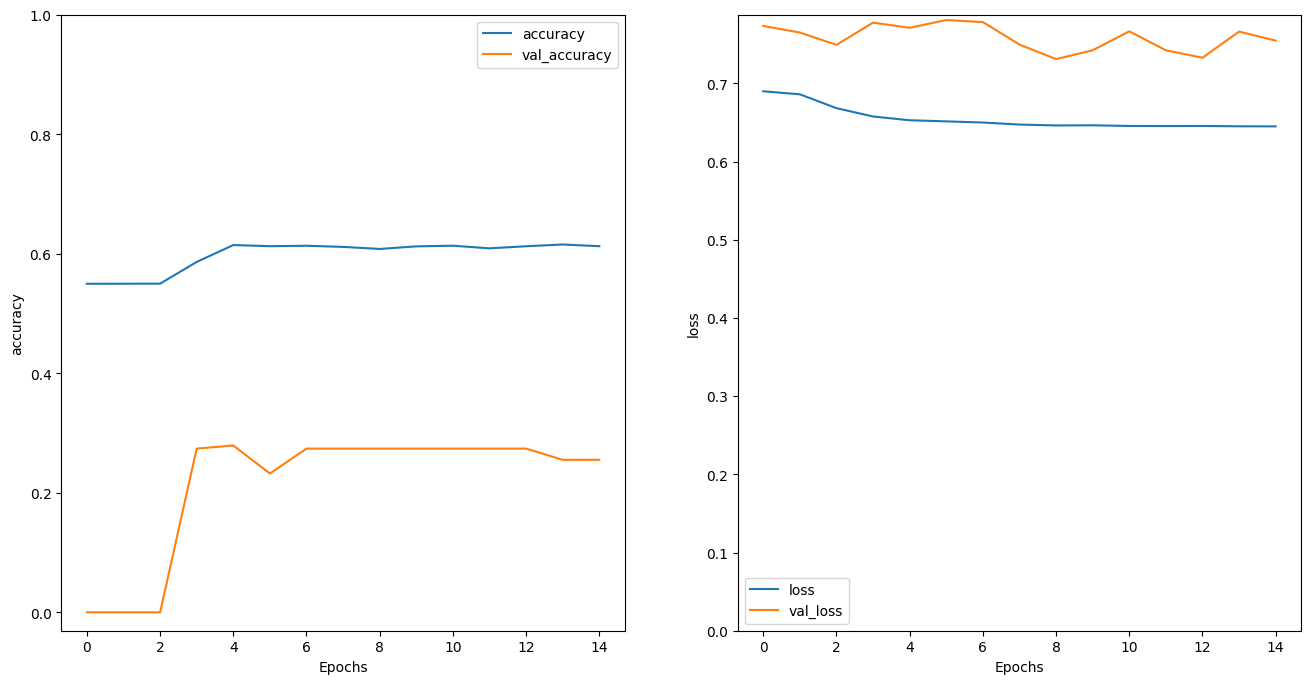

In [30]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [31]:
"""
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\n# predict on a sample text without padding\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'

##### Experiment 3:

In [32]:
tokens_input_len = TOKENS_PAD_TO_MAX_TOKENS 
type_input_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

model = create_model(encoder_count_tokens, encoder_count_types,tokens_input_len, type_input_len) # maybe add 30
# predict on a sample formula using untrained model
#predictions = model.predict(np.array([sample_text]))
#print(predictions[0])

In [33]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15

sample_text = "( A \cup B ) \cap (C \cup D )"
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [34]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "3-tokens-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.5497INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


156/156 [==============================] - 40s 229ms/step - loss: 0.6877 - accuracy: 0.5497 - val_loss: 0.7499 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.5730INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


156/156 [==============================] - 35s 224ms/step - loss: 0.6561 - accuracy: 0.5730 - val_loss: 0.7115 - val_accuracy: 0.2604
Epoch 3/15
156/156 [==============================] - 19s 124ms/step - loss: 0.6331 - accuracy: 0.6316 - val_loss: 0.7407 - val_accuracy: 0.2625
Epoch 4/15
156/156 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.6290INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


156/156 [==============================] - 34s 218ms/step - loss: 0.6284 - accuracy: 0.6290 - val_loss: 0.6945 - val_accuracy: 0.2792
Epoch 5/15
156/156 [==============================] - 19s 122ms/step - loss: 0.6247 - accuracy: 0.6280 - val_loss: 0.7258 - val_accuracy: 0.2729
Epoch 6/15
156/156 [==============================] - 19s 122ms/step - loss: 0.6216 - accuracy: 0.6296 - val_loss: 0.7152 - val_accuracy: 0.2740
Epoch 7/15
156/156 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.6270INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


156/156 [==============================] - 34s 217ms/step - loss: 0.6185 - accuracy: 0.6270 - val_loss: 0.6923 - val_accuracy: 0.2833
Epoch 8/15
156/156 [==============================] - 19s 120ms/step - loss: 0.6161 - accuracy: 0.6265 - val_loss: 0.7206 - val_accuracy: 0.2646
Epoch 9/15
156/156 [==============================] - ETA: 0s - loss: 0.6132 - accuracy: 0.6253INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


156/156 [==============================] - 34s 221ms/step - loss: 0.6132 - accuracy: 0.6253 - val_loss: 0.6796 - val_accuracy: 0.2781
Epoch 10/15
156/156 [==============================] - 22s 139ms/step - loss: 0.6104 - accuracy: 0.6238 - val_loss: 0.6911 - val_accuracy: 0.2698
Epoch 11/15
156/156 [==============================] - ETA: 0s - loss: 0.6075 - accuracy: 0.6272INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


156/156 [==============================] - 35s 226ms/step - loss: 0.6075 - accuracy: 0.6272 - val_loss: 0.6764 - val_accuracy: 0.2740
Epoch 12/15
156/156 [==============================] - ETA: 0s - loss: 0.6054 - accuracy: 0.6305INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_193343-y4u3mf42/files/model-best/assets


156/156 [==============================] - 33s 214ms/step - loss: 0.6054 - accuracy: 0.6305 - val_loss: 0.6474 - val_accuracy: 0.2990
Epoch 13/15
156/156 [==============================] - 20s 129ms/step - loss: 0.6039 - accuracy: 0.6319 - val_loss: 0.7168 - val_accuracy: 0.2531
Epoch 14/15
156/156 [==============================] - 19s 119ms/step - loss: 0.6026 - accuracy: 0.6322 - val_loss: 0.6490 - val_accuracy: 0.3125
Epoch 15/15
156/156 [==============================] - 18s 118ms/step - loss: 0.6008 - accuracy: 0.6353 - val_loss: 0.6606 - val_accuracy: 0.3010


In [35]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 1s 37ms/step - loss: 0.6606 - accuracy: 0.3010
Test Loss: 0.6605526804924011
Test Accuracy: 0.3010416626930237


(0.0, 0.7573715806007385)

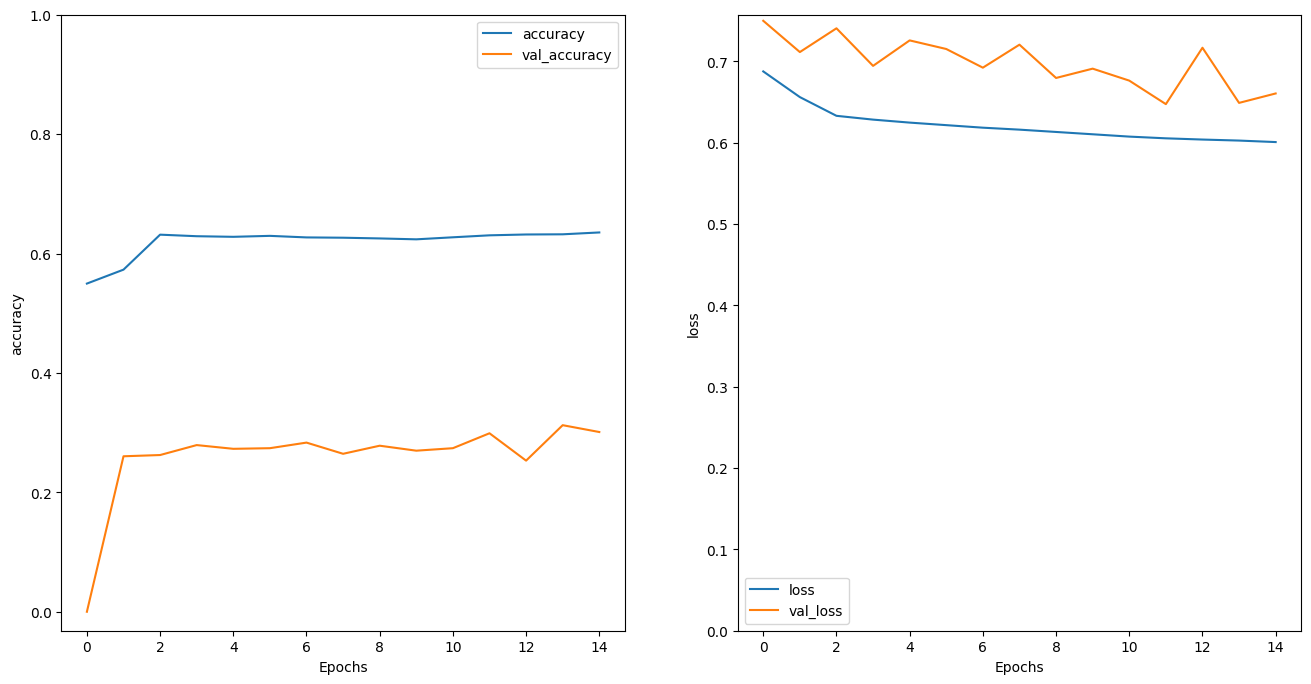

In [36]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [37]:
"""
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\n# predict on a sample text without padding\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'

##### Experiment 4:

In [38]:
tokens_input_len = BIGRAM_PAD_TO_MAX_TOKENS
type_input_len = BIGRAM_PAD_TO_MAX_TOKENS

model = create_model(encoder_bigrams_tokens, encoder_bigrams_types,tokens_input_len, type_input_len) # maybe add 30

# predict on a sample formula using untrained model
#predictions = model.predict(np.array([sample_text]))
#print(predictions[0])

In [39]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15

sample_text = "( A \cup B ) \cap (C \cup D )"
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [40]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_6 (TextVect  (None, 350)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 text_vectorization_7 (TextVect  (None, 350)         0           ['input_6[0][0]']          

In [41]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "3-tokens-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "bigram_count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5501INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


156/156 [==============================] - 72s 425ms/step - loss: 0.6842 - accuracy: 0.5501 - val_loss: 0.7624 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.5566INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


156/156 [==============================] - 67s 430ms/step - loss: 0.6574 - accuracy: 0.5566 - val_loss: 0.7409 - val_accuracy: 0.2375
Epoch 3/15
156/156 [==============================] - 53s 339ms/step - loss: 0.6238 - accuracy: 0.6333 - val_loss: 0.7561 - val_accuracy: 0.2812
Epoch 4/15
156/156 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.6340INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


156/156 [==============================] - 70s 450ms/step - loss: 0.6167 - accuracy: 0.6340 - val_loss: 0.7286 - val_accuracy: 0.2771
Epoch 5/15
156/156 [==============================] - ETA: 0s - loss: 0.6133 - accuracy: 0.6386INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


156/156 [==============================] - 71s 454ms/step - loss: 0.6133 - accuracy: 0.6386 - val_loss: 0.6795 - val_accuracy: 0.2958
Epoch 6/15
156/156 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.6400INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


156/156 [==============================] - 70s 445ms/step - loss: 0.6105 - accuracy: 0.6400 - val_loss: 0.6728 - val_accuracy: 0.3031
Epoch 7/15
156/156 [==============================] - 52s 335ms/step - loss: 0.6085 - accuracy: 0.6400 - val_loss: 0.6889 - val_accuracy: 0.2937
Epoch 8/15
156/156 [==============================] - ETA: 0s - loss: 0.6076 - accuracy: 0.6410INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


156/156 [==============================] - 68s 433ms/step - loss: 0.6076 - accuracy: 0.6410 - val_loss: 0.6688 - val_accuracy: 0.2937
Epoch 9/15
156/156 [==============================] - 52s 334ms/step - loss: 0.6050 - accuracy: 0.6409 - val_loss: 0.6709 - val_accuracy: 0.2937
Epoch 10/15
156/156 [==============================] - 52s 335ms/step - loss: 0.6041 - accuracy: 0.6425 - val_loss: 0.7066 - val_accuracy: 0.2615
Epoch 11/15
156/156 [==============================] - ETA: 0s - loss: 0.6014 - accuracy: 0.6422INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_194034-4b9p3za1/files/model-best/assets


156/156 [==============================] - 67s 430ms/step - loss: 0.6014 - accuracy: 0.6422 - val_loss: 0.6587 - val_accuracy: 0.2875
Epoch 12/15
156/156 [==============================] - 52s 334ms/step - loss: 0.6007 - accuracy: 0.6437 - val_loss: 0.6928 - val_accuracy: 0.2781
Epoch 13/15
156/156 [==============================] - 52s 335ms/step - loss: 0.6005 - accuracy: 0.6416 - val_loss: 0.6730 - val_accuracy: 0.2792
Epoch 14/15
156/156 [==============================] - 52s 336ms/step - loss: 0.5976 - accuracy: 0.6426 - val_loss: 0.6618 - val_accuracy: 0.2865
Epoch 15/15
156/156 [==============================] - 52s 336ms/step - loss: 0.5962 - accuracy: 0.6436 - val_loss: 0.6763 - val_accuracy: 0.2792


In [42]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 2s 103ms/step - loss: 0.6763 - accuracy: 0.2792
Test Loss: 0.6763313412666321
Test Accuracy: 0.27916666865348816


(0.0, 0.7707581430673599)

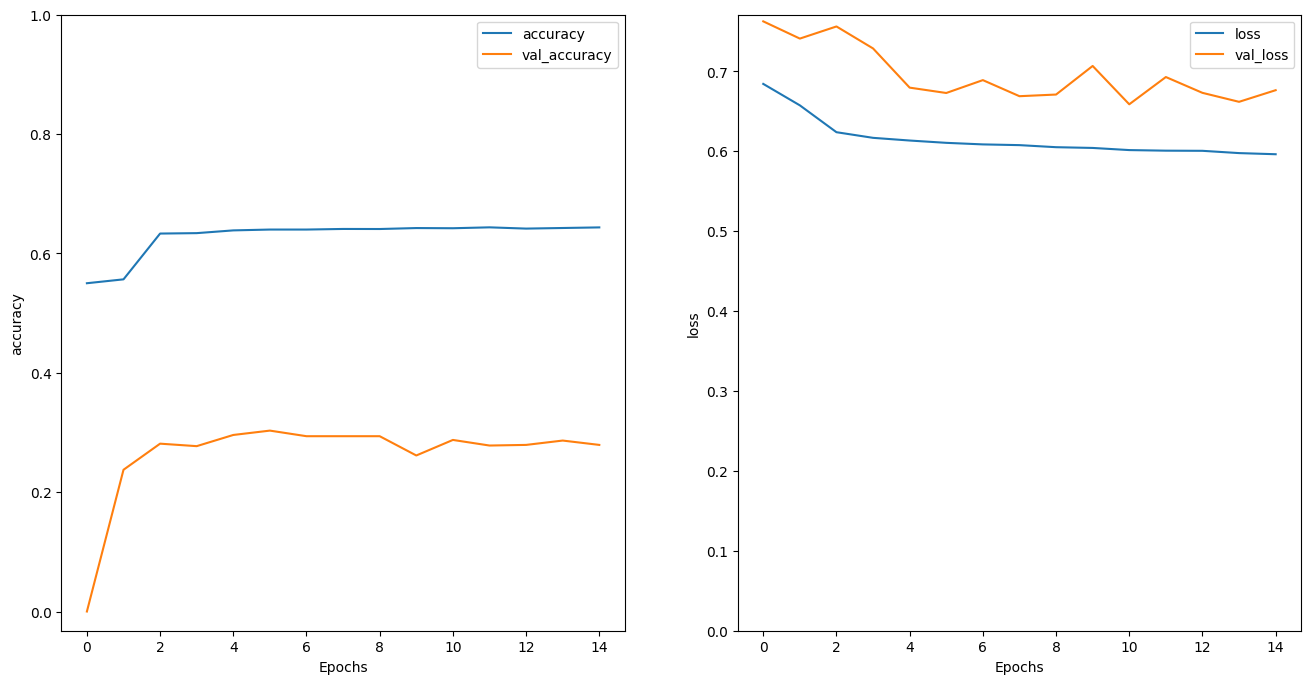

In [43]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [44]:
"""
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\n# predict on a sample text without padding\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'

##### Experiment 5:

In [45]:
tokens_input_len = TOKENS_PAD_TO_MAX_TOKENS 
type_input_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

model_tf_idf = create_model(encoder_tf_idf_tokens, encoder_tf_idf_types,tokens_input_len, type_input_len) # maybe add 30

# predict on a sample formula using untrained model
#predictions = model_tf_idf.predict(np.array([sample_text]))
#print(predictions[0])

In [46]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15
sample_text = "set_constant SET_BASIC"

model_tf_idf.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [47]:
model_tf_idf.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_8 (TextVect  (None, 150)         1           ['input_7[0][0]']                
 orization)                                                                                       
                                                                                                  
 text_vectorization_9 (TextVect  (None, 100)         1           ['input_8[0][0]']          

In [48]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "3-tokens-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "tf_idf",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model_tf_idf.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


156/156 [==============================] - 40s 231ms/step - loss: 0.6712 - accuracy: 0.5500 - val_loss: 0.6864 - val_accuracy: 0.0010
Epoch 2/15
156/156 [==============================] - ETA: 0s - loss: 0.5836 - accuracy: 0.6627INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


156/156 [==============================] - 35s 225ms/step - loss: 0.5836 - accuracy: 0.6627 - val_loss: 0.6514 - val_accuracy: 0.3333
Epoch 3/15
156/156 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.6841INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


156/156 [==============================] - 34s 218ms/step - loss: 0.5490 - accuracy: 0.6841 - val_loss: 0.6267 - val_accuracy: 0.3656
Epoch 4/15
156/156 [==============================] - ETA: 0s - loss: 0.5315 - accuracy: 0.6841INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


156/156 [==============================] - 34s 221ms/step - loss: 0.5315 - accuracy: 0.6841 - val_loss: 0.5650 - val_accuracy: 0.3823
Epoch 5/15
156/156 [==============================] - 19s 122ms/step - loss: 0.5222 - accuracy: 0.6849 - val_loss: 0.5735 - val_accuracy: 0.3865
Epoch 6/15
156/156 [==============================] - 19s 123ms/step - loss: 0.5161 - accuracy: 0.6906 - val_loss: 0.5738 - val_accuracy: 0.4667
Epoch 7/15
156/156 [==============================] - 20s 127ms/step - loss: 0.5111 - accuracy: 0.7078 - val_loss: 0.5678 - val_accuracy: 0.4750
Epoch 8/15
156/156 [==============================] - ETA: 0s - loss: 0.5078 - accuracy: 0.7124INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


156/156 [==============================] - 35s 226ms/step - loss: 0.5078 - accuracy: 0.7124 - val_loss: 0.5513 - val_accuracy: 0.4865
Epoch 9/15
156/156 [==============================] - 29s 186ms/step - loss: 0.5055 - accuracy: 0.7156 - val_loss: 0.5824 - val_accuracy: 0.4729
Epoch 10/15
156/156 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.7168INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


156/156 [==============================] - 52s 333ms/step - loss: 0.5033 - accuracy: 0.7168 - val_loss: 0.5363 - val_accuracy: 0.4917
Epoch 11/15
156/156 [==============================] - 23s 144ms/step - loss: 0.5012 - accuracy: 0.7186 - val_loss: 0.5383 - val_accuracy: 0.4958
Epoch 12/15
156/156 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.7194INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


156/156 [==============================] - 36s 229ms/step - loss: 0.4990 - accuracy: 0.7194 - val_loss: 0.5286 - val_accuracy: 0.5042
Epoch 13/15
156/156 [==============================] - ETA: 0s - loss: 0.4966 - accuracy: 0.7223INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_195554-zs2hsdbs/files/model-best/assets


156/156 [==============================] - 37s 237ms/step - loss: 0.4966 - accuracy: 0.7223 - val_loss: 0.5118 - val_accuracy: 0.5156
Epoch 14/15
156/156 [==============================] - 21s 132ms/step - loss: 0.4959 - accuracy: 0.7225 - val_loss: 0.5440 - val_accuracy: 0.5073
Epoch 15/15
156/156 [==============================] - 21s 131ms/step - loss: 0.4941 - accuracy: 0.7268 - val_loss: 0.5221 - val_accuracy: 0.5188


In [49]:
test_loss, test_acc = model_tf_idf.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 1s 50ms/step - loss: 0.5221 - accuracy: 0.5188
Test Loss: 0.5221454501152039
Test Accuracy: 0.518750011920929


(0.0, 0.695995420217514)

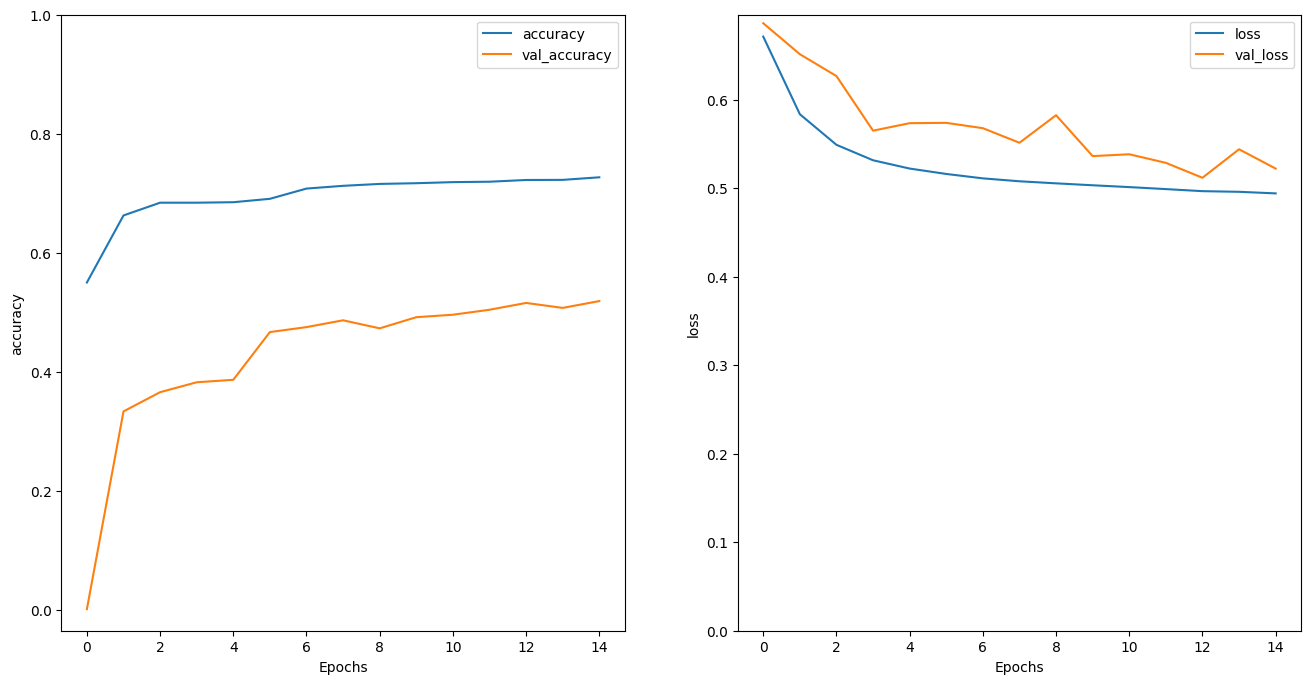

In [50]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [51]:
"""
# predict on a sample text without padding
sample_text = "set_constant SET_BASIC"
predictions = model_tf_idf.predict(np.array([sample_text]))
print(predictions[0])
"""

'\n# predict on a sample text without padding\nsample_text = "set_constant SET_BASIC"\npredictions = model_tf_idf.predict(np.array([sample_text]))\nprint(predictions[0])\n'